# Vanilla RNNs
This notebook is largely background we assume you're somewhat familiar with. The main purpose is to familiarize those who are coming from a TF background to see how to do the relevant things in PyTorch. You'll see that many of the things that were sometimes a pain in TF turn out to be rather straightforward in PyTorch. Let's start by importing the relevant packages and loading in the data:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(0)

In [5]:
def plot_model(model, T, csv_fn):
  dataset_test = pd.read_csv(csv_fn)
  real_stock_price = dataset_test.iloc[:, 1:2].values

  # Getting the predicted stock price of 2017
  dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
  inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
  inputs = inputs.reshape(-1,1)
  inputs = sc.transform(inputs)
  X_test = []

  for i in range(T, inputs.shape[0]):
      X_test.append(torch.tensor(inputs[i-T:i, 0]))

  X_test = torch.stack(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  if model is not None:
    predicted_stock_price = model(X_test).detach().numpy()
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

  # Visualising the results
  plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
  if model is not None:
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
  plt.title('Google Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Google Stock Price')
  plt.legend()
  plt.show()

if not os.path.exists("Google_Stock_Price_Train.csv"):
    url = "https://raw.githubusercontent.com/kevincwu0/rnn-google-stock-prediction/master/Google_Stock_Price_Train.csv"
    urllib.request.urlretrieve(url, "Google_Stock_Price_Train.csv")

if not os.path.exists("Google_Stock_Price_Test.csv"):
    url = "https://raw.githubusercontent.com/kevincwu0/rnn-google-stock-prediction/master/Google_Stock_Price_Test.csv"
    urllib.request.urlretrieve(url, "Google_Stock_Price_Test.csv")

dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values 

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

T = 60
D = 1
H = 8
O = 1

num_pts, _ = training_set_scaled.shape
X_train = []
y_train = []

for i in range(T, num_pts):
  X_train.append(torch.tensor(training_set_scaled[i-T:i]))
  y_train.append(torch.tensor(training_set_scaled[i]))

X_train = np.array(X_train)
y_train = np.array(y_train)

/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_4608/390531928.py:58: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X_train = np.array(X_train)
/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_4608/390531928.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(X_train)
/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel

Let's visualize the data to get a sense of what it looks like:

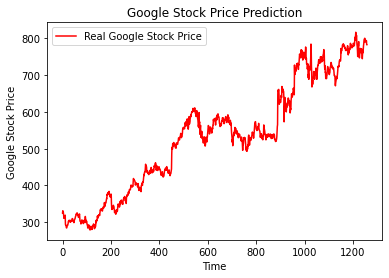

In [6]:
plot_model(None, 60, "Google_Stock_Price_Train.csv")

The data have already been separated into two chunks: `X_train` and `y_train`. These will be what you'll use later for actually training your model. For now, let's start by constructing the model. Recall the following background for RNNs:

The RNN can be represented by a sequence of hidden states $h_1, ..., h_t$, where each hidden state $h_t$ can be computed as some function of the previous hidden state $h_{t-1}$, the current input $x_t$, a set of weights $W$:

$$h_t = f_W(h_{t-1}, x_t)$$

A fixed function $f_W$ with weights $W$ is applied at every single timestep and that allows us to use the Recurrent Neural Network on sequences without having to commit to the size of the sequence because we apply the exact same function at every single timestep, no matter how long the input or output sequences are.

In the most simplest form of RNN, which we call a Vanilla RNN, the network is just a single hidden state $h$ where we use a recurrence formula that basically tells us how we should update our hidden state $h$ as a function of the previous hidden state $h_{t-1}$ and the current input $x_t$. Specifically, in RNNs the following parametric method is used to update the hidden state from time $t-1$ to time $t$: 

$$h_t = tanh(W_{hh}h_{t-1} + W_{xh}x_t + b_h)$$

Here, $W_{hh}$ and $W_{xh}$ are fixed weight matrices (that do not depend on $t$), $b_h$ is a bias vector, and $tanh$ is the hyperbolic tan function. The figure below provides a nice visualization of this recurrence.

![](https://cs231n.github.io/assets/rnn/vanilla_rnn_mformula_1.png)

The hidden state $h_t$  captures information about all previous inputs $x_1, ... x_{t-1}$  and fully parameterizes the RNN at time point $t$ in the input sequence . A prediction at time point $t$, $\hat{y}_t$, can thus be computed exclusively using $h_t$,  another weight matrix $W_{o}$, and another bias $b_o$ as follows: 

$$\hat{y}_t = W_{o}h_t + b_o$$


![](https://cs231n.github.io/assets/rnn/vanilla_rnn_mformula_2.png)

A few comments about $W_{hy}$, $W_{xh}$, $W_{o}$, $b_h$, and $b_o$. Note that wthese eights are not subscripted by $t$. This means that these weight are *shared* across all timesteps of the input sequence. These weights are also the trainable parameters that need to be learnt and updated during gradient descent and back propagation. 

Let's go ahead and implement this, ignoring the bias terms for simplicity:

In [7]:
class VanillaRNN(nn.Module):
    def __init__(self, D, H, O):
        super(VanillaRNN, self).__init__()

        self.D = D
        self.H = H
        self.O = O

        self.Wxh = nn.Parameter(torch.ones((self.D, self.H)).type(torch.DoubleTensor))
        self.Whh = nn.Parameter(torch.ones((self.H, self.H)).type(torch.DoubleTensor))
        self.Who = nn.Parameter(torch.ones((self.H, self.O)).type(torch.DoubleTensor))

    def forward(self, x):
        h = torch.zeros(self.H).type(torch.DoubleTensor)

        N, T, D = x.shape
        for t in range(T):
            x_i = x[:, t, :]
            h = torch.tanh(torch.matmul(x_i, self.Wxh) + torch.matmul(h, self.Whh))

        y_hat = torch.matmul(h, self.Who)
        return y_hat

In [8]:
# Use the below to test your VanillaRNN
T = 60
D = 1
H = 8
O = 1

model = VanillaRNN(D, H, O)
prediction = model(torch.stack([X_train[100]])).data[0,0].numpy()
assert(np.isclose(prediction, 8, atol=1e-05))

Great! Now, let's train it using the `X_train` and `y_train`. You'll want to do random sampling of `X_train` and `y_train` to create mini-batches for training. https://stackoverflow.com/questions/19485641/python-random-sample-of-two-arrays-but-matching-indices will be useful for that.

For a reference of how to write a training loop, take a look at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [9]:
"""
TODO: Implement the training loop for your model. Use MSELoss
for the loss. Visualize the results in the cell below. You should see
near perfect alignment for the first visualization and somewhat decent
prediction for the latter
"""

model = VanillaRNN(D, H, O)

loss_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
batch_size = 128
epochs = 2000

losses = []

for epoch in range(epochs):
    optimizer.zero_grad()

    idx = np.random.choice(np.arange(X_train.shape[0]), batch_size, replace=False)
    X_sample = torch.stack(list(X_train[idx]))
    y_sample = torch.stack(list(y_train[idx]))

    y_hat = model(X_sample)
    loss = loss_criterion(y_hat, y_sample)
    loss.backward()

    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epochs: {epoch}/{epochs} -- Loss: {loss}")
    losses.append(loss.detach().numpy())

Epochs: 0/2000 -- Loss: 56.449076846584305
Epochs: 100/2000 -- Loss: 45.27099161674711
Epochs: 200/2000 -- Loss: 35.59567408026994
Epochs: 300/2000 -- Loss: 27.577816756174872
Epochs: 400/2000 -- Loss: 0.030725630563397156
Epochs: 500/2000 -- Loss: 0.0004007822217901078
Epochs: 600/2000 -- Loss: 0.000338279223845614
Epochs: 700/2000 -- Loss: 0.00020134222931785726
Epochs: 800/2000 -- Loss: 0.000548226026033979
Epochs: 900/2000 -- Loss: 0.00022577330987320408
Epochs: 1000/2000 -- Loss: 0.0002191797938525749
Epochs: 1100/2000 -- Loss: 0.00041599442702943296
Epochs: 1200/2000 -- Loss: 0.0002243424091465943
Epochs: 1300/2000 -- Loss: 0.00034139658896830896
Epochs: 1400/2000 -- Loss: 0.0003401745435391295
Epochs: 1500/2000 -- Loss: 0.0003062402024533922
Epochs: 1600/2000 -- Loss: 0.0006631902401923299
Epochs: 1700/2000 -- Loss: 0.00030371030382091797
Epochs: 1800/2000 -- Loss: 0.0004982178106437901
Epochs: 1900/2000 -- Loss: 0.00034214033049844025


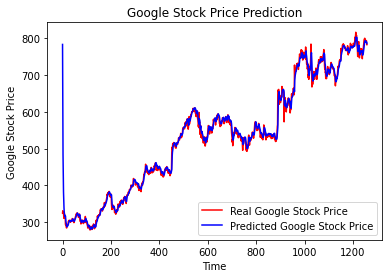

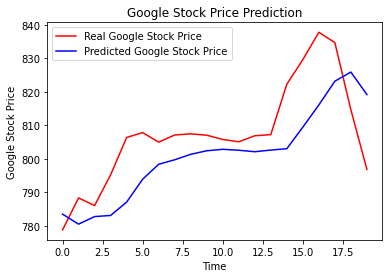

In [10]:
plot_model(model, T, "Google_Stock_Price_Train.csv") # should be nearly perfectly fit
plot_model(model, T, "Google_Stock_Price_Test.csv")